# Maximum Likelihood Estimation of Custom Models in Python with StatsModels
based on http://austinrochford.com/posts/2015-03-03-mle-python-statsmodels.html

## Distribution
Uses custom [zero-inflated Poisson model](https://en.wikipedia.org/wiki/Zero-inflated_model).

$$
P(X = 0) = \pi + (1 - \pi) e^ {-\lambda}
$$
$$
P(X = x) = (1 - \pi) e ^{-\lambda} \frac{\lambda^{x}}{x!},
$$
for $x > 0$.

In [1]:
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
from scipy import stats
import seaborn as sns
from statsmodels.base.model import GenericLikelihoodModel

# list available fonts: [f.name for f in matplotlib.font_manager.fontManager.ttflist]
# fix warning: /opt/conda/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
matplotlib.rc('font', family='DejaVu Sans')

pi_default = 0.3
lambda_default = 2.0

In [2]:
def zip_pmf(x, pi=pi_default, lambda_=lambda_default):
    if pi < 0 or pi > 1 or lambda_ <= 0:
        return np.zeros_like(x)
    else:
        return (x == 0) * pi + (1 - pi) * stats.poisson.pmf(x, lambda_)

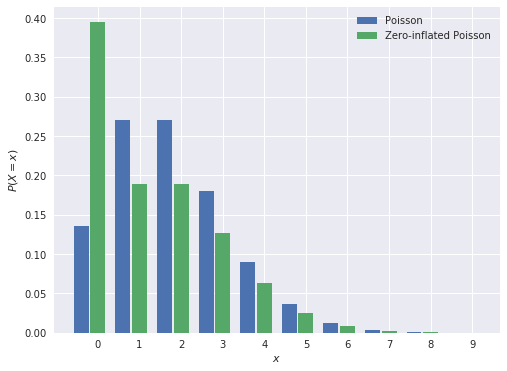

In [3]:
fig, ax = plt.subplots(figsize=(8, 6))

xs = np.arange(0, 10);

palette = sns.color_palette()

ax.bar(2.5 * xs, stats.poisson.pmf(xs, lambda_default), width=0.9, color=palette[0], label='Poisson');
ax.bar(2.5 * xs + 1, zip_pmf(xs), width=0.9, color=palette[1], label='Zero-inflated Poisson');

ax.set_xticks(2.5 * xs + 1);
ax.set_xticklabels(xs);
ax.set_xlabel('$x$');

ax.set_ylabel('$P(X = x)$');

ax.legend();
plt.show()